# Setup

In [2]:
%matplotlib inline

import torch
import random
import copy
import numpy as np
import pandas as pd
import seaborn as sns

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.autograd import Variable
from torchvision import datasets, transforms
from operator import itemgetter

sns.set()

# Dataloaders

In [ ]:
torch.manual_seed(1);

In [12]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       #transforms.Normalize((0.1307,), (0.3081,)) #normalise pixels using mean and stdev
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #normalise to range -1 to 1
                   ])



MNIST_train = datasets.MNIST(r'D:\Data_sets/MNIST', train=True, download=True,
                   transform=transform)

MNIST_test = datasets.MNIST(r'D:\Data_sets/MNIST', train=False, download=True,
                   transform=transform)

In [14]:
train_loader = torch.utils.data.DataLoader(MNIST_train, 
                                           batch_size=64, 
                                           shuffle=True, 
                                           pin_memory=True)

test_loader = torch.utils.data.DataLoader(MNIST_test,
                                          batch_size=1000, 
                                          shuffle=True, 
                                          pin_memory=True)

# Hyperparameter space

In [2]:
LAYER_SPACE = {
    'nb_units':{'lb': 128, 'ub':1024, 'mutate': 0.15},
    'dropout_rate': {'lb': 0.0, 'ub': 0.7, 'mutate': 0.2},
    'activation': {'func': ['linear','tanh','relu','sigmoid','elu'], 'mutate':0.2}
}

In [3]:
NET_SPACE = {
    'nb_layers': {'lb': 1, 'ub': 3, 'mutate': 0.15},
    'lr': {'lb': 0.001, 'ub':0.1, 'mutate': 0.15},
    'weight_decay': {'lb': 0.00001, 'ub': 0.0004, 'mutate':0.2},
    'optimizer': {'func': ['sgd', 'adam', 'adadelta','rmsprop'], 'mutate': 0.2}
}

# Randomise network

In [4]:
def random_value(space):
    """Returns random value from space."""
    
    val = None
    
    if 'func' in space: #randomise optimiser or activation function
        val = random.sample(space['func'], 1)[0] 
    
    elif isinstance(space['lb'], int): #randomise number of units or layers
        val = random.randint(space['lb'], space['ub'])
    
    else: #randomise percentages, i.e. dropout rates or weight decay
        val = random.random() * (space['ub'] - space['lb']) + space['lb']
    
    return val

In [5]:
def randomize_network(layer_space, net_space): 
    """Returns a randomised neural network"""
    net = {}
    
    for key in net_space.keys():
        net[key] = random_value(net_space[key])
        
    layers = []
    
    for i in range(net['nb_layers']):
        layer = {}
        for key in layer_space.keys():
            layer[key] = random_value(layer_space[key])
        layers.append(layer)
        net['layers'] = layers
        
    return net

In [6]:
randomize_network(LAYER_SPACE, NET_SPACE)

{'layers': [{'activation': 'elu',
   'dropout_rate': 0.2953273247779448,
   'nb_units': 863},
  {'activation': 'sigmoid',
   'dropout_rate': 0.49018793842203023,
   'nb_units': 288}],
 'lr': 0.03850809968690585,
 'nb_layers': 2,
 'optimizer': 'rmsprop',
 'weight_decay': 0.0002889649100417271}

# Mutate network

In [368]:
def mutate_net(nnet, layer_space, net_space):
    
    net = copy.deepcopy(nnet)
    
    
    # mutate optimizer
    for k in ['lr', 'weight_decay', 'optimizer']:
        if random.random() < net_space[k]['mutate']:
            net[k] = random_value(net_space[k])
    
    
    # mutate layers
    for layer in net['layers']:
        for k in layer_space.keys():
            if random.random() < layer_space[k]['mutate']:
                layer[k] = random_value(layer_space[k])
                
                
    # mutate number of layers -- 50% add 50% remove
    if random.random() < net_space['nb_layers']['mutate']:
        if net['nb_layers'] <= net_space['nb_layers']['ub']:
            if random.random()< 0.5 and \
            net['nb_layers'] < net_space['nb_layers']['ub']:
                layer = {}
                for key in layer_space.keys():
                    layer[key] = random_value(layer_space[key])
                net['layers'].append(layer)      
            else:
                if net['nb_layers'] > 1:
                    net['layers'].pop()

                
            # value & id update
            net['nb_layers'] = len(net['layers'])         
            
    return net

# NetBuilder

In [8]:
class Flatten(nn.Module):
    """Flattens input to vector size (batchsize, 1)
    (for use in NetFromBuildInfo)."""

    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.size(0), -1)

In [49]:
class NetFromBuildInfo(nn.Module):
    def __init__(self, build_info):
        super(NetFromBuildInfo, self).__init__()
        
        self.activation_dict = {
            'tanh': nn.Tanh(),
            'relu': nn.ReLU(),
            'sigmoid': nn.Sigmoid(),
            'elu': nn.ELU()
            }

        #NETWORK DEFINITION
        
        previous_units = 28 * 28 #MNIST shape
        
        self.model = nn.Sequential()
        self.model.add_module('flatten', Flatten())
         
        for i, layer_info in enumerate(build_info['layers']):
            i = str(i)
            
            self.model.add_module(
                'fc_' + i,
                nn.Linear(previous_units, layer_info['nb_units'])
                )
            
            previous_units = layer_info['nb_units']
            
            self.model.add_module(
                'dropout_' + i,
                nn.Dropout(p=layer_info['dropout_rate'])
                )
            if layer_info['activation'] == 'linear':
                continue #linear activation is identity function
            self.model.add_module(
                layer_info['activation']+ i,
                self.activation_dict[layer_info['activation']])

        self.model.add_module(
            'logits',
            nn.Linear(previous_units, 10) #10 MNIST classes
            )
        
        
        ##OPTIMIZER

        self.opt_args = {#'params': self.model.parameters(),
                 'weight_decay': build_info['weight_decay'],
                 'lr': build_info['lr']
                 }
        
        self.optimizer_dict = {
            'adam': optim.Adam(self.model.parameters(),**self.opt_args),
            'rmsprop': optim.RMSprop(self.model.parameters(),**self.opt_args),
            'adadelta':optim.Adadelta(self.model.parameters(),**self.opt_args),
            'sgd': optim.SGD(self.model.parameters(), **self.opt_args, momentum=0.9) #momentum to train faster
            }

        self.optimizer = self.optimizer_dict[build_info['optimizer']]
        
        
    def forward(self, x):
        x = self.model(x)
        return F.log_softmax(x, dim=1)

In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Train test helpers

In [195]:
def train(model, train_loader, optimizer, epoch):
    
    model.train(True)
    
    running_loss = 0.0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        
        data, target = Variable(data.cuda()), Variable(target.cuda())
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward() 
        optimizer.step()
        running_loss += loss.item()

    running_loss /= len(train_loader.dataset)    
    
    if epoch % 3 == 0:
        print('Train Epoch: {} \t Loss: {:.6f}'.format(epoch, running_loss ))

In [196]:
def test(model, test_loader):
    
    model.train(False)
    
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        
        for data, target in test_loader:
            
            data, target = data.cuda(), target.cuda()
            output = model(data)
            
            test_loss += F.nll_loss(output, target, size_average=False).item()
            
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    
    
    return (test_loss, correct)

# Evolution optimiser

In [377]:
class TournamentOptimizer:
    """Define a tournament play selection process."""

    def __init__(self, population_sz, layer_space, net_space, init_fn, mutate_fn, builder_fn,
                 train_fn, test_fn, dataloader, testloader):
        
        self.init_fn = init_fn
        self.layer_space = layer_space
        self.net_space = net_space
        self.mutate_fn = mutate_fn
        self.builder_fn = builder_fn
        self.train = train_fn
        self.test = test_fn
        self.dataloader = dataloader
        self.testloader = testloader
        self.population_sz = population_sz
        
        torch.manual_seed(1);
        
        self.genomes = [init_fn(self.layer_space, self.net_space) for i in range(population_sz)]   
        self.population = [NetFromBuildInfo(i).cuda() for i in self.genomes] #randomize population of nets     
        
        self.test_results = {} 
        self.genome_history = {} 

        self.generation = 0

    def step(self):
        """Tournament evolution step."""

        genome_holder = [] 
        
        self.generation += 1
        
        self.genome_history[self.generation] = self.genomes

        self.train_nets()
        self.evaluate_nets()

        mean = np.mean(self.test_results[self.generation]['correct'])
        best = np.max(self.test_results[self.generation]['correct'])
        
        print('\nPopulation mean:{} max:{}'.format(mean, best))
        
        
        children = []
        n_elite = 2
        sorted_pop = np.argsort(self.test_results[self.generation]['correct'])[::-1]
        elite = sorted_pop[:n_elite]
        


        # elites always included in the next population
        self.elite = []
        print('\nTop performers:')
        for no, i in enumerate(elite):
            self.elite.append((self.test_results[self.generation]['correct'][i], 
                               self.population[i]))    
            
            genome_holder.append(self.genomes[i])
            
            print("{}: score:{}".format(no, self.test_results[self.generation]['correct'][i]))   
            
            children.append(self.population[i])
            
            
            
        #https://stackoverflow.com/questions/31933784/tournament-selection-in-genetic-algorithm
        p = 0.85 # winner probability 
        tournament_size = 3
        probs = [p*((1-p)**i) for i in range(tournament_size-1)]
        probs.append(1-np.sum(probs))
        #probs = [0.85, 0.1275, 0.0224]
        
        while len(children) < self.population_sz:
            pop = range(len(self.population))
            sel_k = random.sample(pop, k=tournament_size)
            fitness_k = list(np.array(self.test_results[self.generation]['correct'])[sel_k])
            selected = zip(sel_k, fitness_k)
            rank = sorted(selected, key=itemgetter(1), reverse=True)
            pick = np.random.choice(tournament_size, size=1, p=probs)[0]
            best = rank[pick][0]
            genome = self.mutate_fn(self.genomes[best], self.layer_space, self.net_space)
            print('mutated: ', best)
            
            genome_holder.append(genome)
            model =  self.builder_fn(genome).cuda()
            children.append(model)


            
        self.population = children
        self.genomes = genome_holder

        
        #<----------- add all new genomes to genome history --------->
        
    def train_nets(self):
        
        for i, net in enumerate(self.population):
            for epoch in range(1, 2):
                
                torch.manual_seed(1);
                
                self.train(net, self.dataloader, net.optimizer, epoch)
                print('model {} trained'.format(i))
                
                fp = r"D:\Models\NeuroEvolution/{}-{}".format(self.generation, i)
                torch.save(net.state_dict(), fp)
                
                
                
    def evaluate_nets(self):
        """evaluate the models."""
        
        losses = []
        corrects = []
        
        self.test_results[self.generation] = {}
        
        for i in range(len(self.population)):
            net = self.population[i]
            loss, correct = self.test(net, self.testloader)
            
            losses.append(loss)
            corrects.append(correct)
        
        self.test_results[self.generation]['losses'] = losses
        self.test_results[self.generation]['correct'] = corrects

# Run 

In [387]:
testing = TournamentOptimizer(10, LAYER_SPACE, NET_SPACE, randomize_network, 
                           mutate_net, NetFromBuildInfo, train, test,
                          train_loader, test_loader)

In [388]:
for i in range(2):
    testing.step()

model 0 trained
model 1 trained
model 2 trained
model 3 trained
model 4 trained
model 5 trained
model 6 trained
model 7 trained
model 8 trained
model 9 trained

Population mean:5932.0 max:9351

Top performers:
0: score:9351
1: score:9238
mutated:  9
mutated:  9
mutated:  5
mutated:  7
mutated:  0
mutated:  7
mutated:  2
mutated:  6
model 0 trained
model 1 trained
model 2 trained
model 3 trained
model 4 trained
model 5 trained
model 6 trained
model 7 trained
model 8 trained
model 9 trained

Population mean:6945.1 max:9511

Top performers:
0: score:9511
1: score:9457
mutated:  4
mutated:  2
mutated:  0
mutated:  5
mutated:  0
mutated:  0
mutated:  4
mutated:  5


In [382]:
def rebuild_from_save(optimizer, generation, position):
    
    genome = optimizer.genome_history[generation][position]
    
    net = NetFromBuildInfo(genome)
    
    net.load_state_dict(torch.load(r"D:\Models\NeuroEvolution\{}-{}".format(generation, position)))
    
    return net.cuda()

In [383]:
def sanity_check(optimizer, test_loader):
    
    for generation in optimizer.test_results:
        print('generation 1: \n')
        for i, result in enumerate(optimizer.test_results[generation]['correct']):
            
            mod = rebuild_from_save(optimizer, generation, i)
            _, rebuild_result = test(mod, test_loader)
            
            if result == rebuild_result:
                print("result = {}, rebuild result = {}. (equal)".format(result, rebuild_result))
            else:
                print("result = {}, rebuild result = {}. (different!!)".format(result, rebuild_result))
            

In [389]:
sanity_check(testing, test_loader)

generation 1: 

result = 9138, rebuild result = 9138
result = 958, rebuild result = 958
result = 1212, rebuild result = 1212
result = 9096, rebuild result = 9096
result = 1032, rebuild result = 1032
result = 9238, rebuild result = 9238
result = 1009, rebuild result = 1009
result = 9178, rebuild result = 9178
result = 9108, rebuild result = 9108
result = 9351, rebuild result = 9351
generation 1: 

result = 9511, rebuild result = 9511
result = 9457, rebuild result = 9457
result = 9368, rebuild result = 9368
result = 9371, rebuild result = 9371
result = 9218, rebuild result = 9218
result = 9175, rebuild result = 9175
result = 2217, rebuild result = 2217
result = 9167, rebuild result = 9167
result = 958, rebuild result = 958
result = 1009, rebuild result = 1009


In [5]:
ads = np.load('D:/Data_sets/Adversarial/MNIST/adversarials.npy')

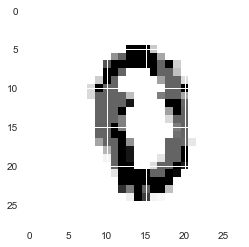

In [8]:
plt.imshow(ads[0].reshape(28,28), cmap='Greys')